# Planning and temporal abstraction
### Jianing Sun 260791202
## Trace 1
Implement Dyna-Q and reproduce the blocking maze and shortcut maze experiments (see page 135, 136 in Sutton & Barto) in Pycolab. 

In [0]:
! pip install git+https://github.com/deepmind/pycolab.git

### 1. Create environment based on Pycolab

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pycolab import ascii_art
from pycolab.prefab_parts import sprites as prefab_sprites

class my_maze:
  
  def __init__(self):
    pass
    
  def make_game(self,GAME_ART):
#       print(self)
      return ascii_art.ascii_art_to_game(
          GAME_ART, what_lies_beneath=' ',
          sprites={'P': PlayerSprite})

class PlayerSprite(prefab_sprites.MazeWalker):
    """A `Sprite` for our player.

    This `Sprite` ties actions to going in the four cardinal directions. If we
    reach a magical location (in this example, (4, 3)), the agent receives a
    reward of 1 and the epsiode terminates.
    """

    def __init__(self, corner, position, character):
        """Inform superclass that we can't walk through walls."""
        super(PlayerSprite, self).__init__(
            corner, position, character, impassable='#')

    def update(self, actions, board, layers, backdrop, things, the_plot):
        del layers, backdrop, things  # Unused.

        # Apply motion commands.
        if actions == 0:  # walk upward?
            self._north(board, the_plot)
        elif actions == 1:  # walk downward?
            self._south(board, the_plot)
        elif actions == 2:  # walk leftward?
            self._west(board, the_plot)
        elif actions == 3:  # walk rightward?
            self._east(board, the_plot)

        # See if we've found the mystery spot.
        if self.position == (1, 9):
            the_plot.add_reward(1.0)
            the_plot.terminate_episode()

### 2. Define blocking maze

In [0]:
import matplotlib.pyplot as plt
import numpy as np
def blockingMaze():
    """ draw the maze, set the start and goal state
    :return:
    """
    # blocking maze would change to 2 after 1000 steps
    Blocking_Maze_1 = ['###########',
                       '#         #',
                       '#         #',
                       '#         #',
                       '######### #',
                       '#         #',
                       '#   P     #',
                       '###########']

    Blocking_Maze_2 = ['###########',
                       '#         #',
                       '#         #',
                       '#         #',
                       '# #########',
                       '#         #',
                       '#   P     #',
                       '###########']

    maxTimeSteps = 3000

    return Blocking_Maze_1, Blocking_Maze_2, maxTimeSteps

### 3. Blocking Maze Dyna-Q & Dyna-Q+ Algorithm

In [0]:
def epi_greedy(currentState, Q, dynaparams):
    """ one-time trail for decision if explore or exploit
    if explore, choose an random action among up, right, left, down
    if exploit, choose the greedy policy (action with the max value)
    :param currentState:
    :param Q: current state-value function
    :param dynaparams: epsilon = 0.1, 10% for exploration
    :return: return an action
    """
    if np.random.binomial(1, dynaparams.eps) == 1:
        # explore
        return np.random.choice([0, 1, 2, 3])
    else:
        # exploit
        # pick the slice action value with current state
        values = Q[currentState[0], currentState[1], :]
        # all the values are same, then randomly choose an action
        # return np.random.choice([0, 1, 2, 3])
        return np.random.choice([action for action, value in enumerate(values) if value == np.max(values)])


def obverse_action(action, game, maze):
    """ action taken observation
    :param action: selected action after epsilon greedy
    :param game: current environment
    :return: reward and next state
    """
    # get next state and current action reward (0 or 1)
    obs, reward, game = checkGameOver(game, action, maze)

    state_array = np.array(obs.layers['P'], dtype=float)
    # TODO: how to get current position directly without searching....
    for i in range(len(state_array)):
        for j in range(len(state_array[0])):
            if state_array[i, j] == 1.0:
                next_state = [i, j]
                break
    return reward, next_state, game


def checkGameOver(game, action, maze):
    """ check if the engine arrive the terminal state
        if game over, re-generate the game environment and get the observation
    :param game: game for checking
    :param action: selected action
    :param maze: in case need to change the maze1 to maze2
    :return: return current observation, reward and the game
    """
    if game.game_over:
        game = env.make_game(maze)
        obs, reward, gamma = game.its_showtime()
        print("Game Over")
        # print(game.game_over)
        # print(np.array(obs.layers['P'], dtype=np.float))
    else:
        obs, reward, gamma = game.play(action)

    return obs, reward, game

class Model_QPlus:
    """ The Dyna-Q+ agent was changed in two other ways.
    First, actions that had never been tried before from a state were allowed to be
    consider in the model planning step of Dyna;
    Second, the initial model for Dyna-Q for such actions was that they would lead
    back to the same state with a reward of zero
    In short, Dyna-Q+ is Dyna-Q with an exploration bonus that encourages exploration
    *** counter: used to measure elapsed time for an action be selected twice
    """
    def __init__(self, rand=np.random, bonus=1e-7):
        self.model = dict()
        self.rand = rand
        self.counter = 0
        self.bonus = bonus

    def update(self, state, action, next_state, reward):
        """ compared with Dyna-Q, extend our tabular with counter parameter """
        self.counter += 1  # counter will be auto-incrementing every time
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()
            # consider never selected actions for a state
            for exploreAction in [0, 1, 2, 3]:
                if exploreAction != action:
                    # initialize explore actions with rewards 0 and counter 1
                    self.model[tuple(state)][exploreAction] = [list(next_state), 0, 1]
        # save to Tabular
        # once an action has already been selected, its counter with be updated with current counter
        self.model[tuple(state)][action] = [list(next_state), reward, self.counter]

    def planning(self):
        """ during planning phase, if selected the exploreAction which with counter 1,
        reward with plus bonus """
        stateIndex = self.rand.choice(range(0, len(self.model.keys())))
        stateRandom = list(self.model)[stateIndex]
        actionIndex = self.rand.choice(range(0, len(self.model[stateRandom].keys())))
        actionRandom = list(self.model[stateRandom])[actionIndex]
        next_state, reward, counter = self.model[stateRandom][actionRandom]

        # higher reward would encourage exploration
        reward += self.bonus * np.sqrt((self.counter - counter))
        return list(stateRandom), actionRandom, list(next_state), reward


class Model:
    """ build the model for planning
    update(state, action, next_state, reward): make a look-up tabular model: {(state): {action: [next_state], reward}}
                                             ex. {(3, 2): {2: [[3, 3], 0]}}
    planning(): return
    """
    def __init__(self, rand=np.random):
        self.model = dict()
        self.rand = rand

    def update(self, state, action, next_state, reward):
        # make a look-up tabular model: {(state): {action: [next_state], reward}}
        # {(3, 2): {2: [[3, 3], 0]}}
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()
        self.model[tuple(state)][action] = [next_state, reward]

    def planning(self):
        stateIndex = self.rand.choice(range(0, len(self.model.keys())))
        stateRandom = list(self.model)[stateIndex]
        actionIndex = self.rand.choice(range(0, len(self.model[stateRandom].keys())))
        actionRandom = list(self.model[stateRandom])[actionIndex]
        next_state, reward = self.model[stateRandom][actionRandom]

        return list(stateRandom), actionRandom, list(next_state), reward


def dyna_Q(Q, model, dynaparams, game, maze):
    """ Dyna Q algorithm implement
    :param Q: state-value function
    :param model: model for planning
    :param dynaparams: hyper-parameters
    :param maze: current environment
    :return:
    """
    # every time start from the START_STATE
    currentState = START_STATE
    steps = 0

    """ stop until arrive goal state """
    while currentState != STOP_STATE:
        steps += 1
        """ epsilon-greedy """
        a = epi_greedy(currentState, Q, dynaparams)
        # execute action a; obverse resultant reward, R, and state, S'
        r, s_, game = obverse_action(a, game, maze)

        if r is None:  # not goal state
            r = 0.0

        # print("reward: {}. newState: {}.".format(r, s_))
        """ Q-learning update: direct RL"""
        Q[currentState[0], currentState[1], a] += \
                    dynaparams.alpha * (r + dynaparams.gamma * np.max(Q[s_[0], s_[1], :]) -
                    Q[currentState[0], currentState[1], a])
        """ deterministic env, update the model """
        model.update(currentState, a, s_, r)

        """ model planning: repeat n steps, Q function update through planning """
        for i in range(0, dynaparams.planSteps):
            stateRandom, actionRandom, next_state, reward = model.planning()

            Q[stateRandom[0], stateRandom[1], actionRandom] += dynaparams.alpha * (reward + dynaparams.gamma *
                         np.max(Q[next_state[0], next_state[1], :] - Q[stateRandom[0], stateRandom[1], actionRandom]))
        currentState = s_

        if steps > maxTimeSteps:
            print(maxTimeSteps)
            break

    return steps


def getReward(Q, dynaparams, game, maxTimeSteps, steps2change, maze):
    """ calculate cumulative reward
    Args:
        Q: initial state-value function
        dynaparams: hyperparameters for dyna algorithm
        maze: environment input in order to get the right next state (used later in dyna algorithm function)
        max_timesteps, steps2change set up same as implementBM
    Return:
        return acclimatized reward
    """
    # accumulate reward for 3000/6000 steps (same value but not the same with time steps) with dyna algorithm
    oneEpisodeSteps = maxTimeSteps

    rewards = np.zeros((2, oneEpisodeSteps))

    for times in range(0, dynaparams.episodes):

        model = [Model(), Model_QPlus()]

        """initialize rewards for 3000 steps"""
        # rewards used to get the average of cumulative rewards
        rewards_ = np.zeros((2, oneEpisodeSteps))

        newQ = [np.copy(Q), np.copy(Q)]
        # print(newQ)
        for i in range(0, len(dynaparams.method)):

            # steps save the current step index, lastSteps save the last step index for arriving goal state
            steps = 0
            lastSteps = 0

            """ for one episode """
            while steps < oneEpisodeSteps:
                # how many steps used for arriving the goal state
                # if maze == Maze1:
                #     print("Maze1")
                # elif maze == Maze2:
                #     print("Maze2")
                steps += dyna_Q(newQ[i], model[i], dynaparams, game, maze)
                # in case bigger than the max value
                steps_ = min(steps, oneEpisodeSteps - 1)
                # print("steps", steps)

                """ reward accumulation: value between two successive steps index, set as the value of last step
                        for new steps index, plus one """
                rewards_[i, lastSteps: steps_] = rewards_[i, lastSteps]
                rewards_[i, steps_] = rewards_[i, lastSteps] + 1
                lastSteps = steps

                # more than 1000 steps, change the environment to Maze2
                if steps > steps2change:
                    maze = Maze2
                    game = env.make_game(maze)
                    game.its_showtime()
                else:
                    maze = Maze1
                    game = env.make_game(maze)
                    game.its_showtime()

        # get the final averaged rewards
        rewards += rewards_

    # final rewards
    rewards /= dynaparams.episodes
    return rewards


def implementBM():

    """ implement blocking maze experiment with first 1000 steps in Maze1 last 2000 steps in Maze2
    Arg:
        maze:input maze, make the environment based on the maze
    Func: setup initial parameters (width, height, max steps and steps to change)
          modify dyna algorithm parameters (alpha for Q-learning, planning steps)
          calculate the cumulative reward and plot final figure
    """
    # initialize a maze and get its shape parameters
    maze = Maze1
    maze_height = len(maze)
    maze_width = len(maze[0])
    # make an environment (game)
    game = env.make_game(maze)
    game.its_showtime()
    # initialize state value function with height, width, action numbers of the maze
    # Q = np.zeros((maze_height, maze_width, 4))
    Q = np.random.rand(maze_height, maze_width, 4)

    # define max time steps
    # max_timesteps = 3000

    # which step to change the maze
    steps2change = 1000

    # reset hyper-parameters
    dynaparams = DynaParams()
    dynaparams.alpha = 0.7
    dynaparams.planSteps = 5  # 15 -> 25
    dynaparams.eps = 0.1

    """ get the cumulative reward used for plotting and change the maze after 1000 time steps """
    rewards = getReward(Q, dynaparams, game, maxTimeSteps, steps2change, maze)

    """ plot figure of example 8.2 """
    plt.figure(1)
#     for i in range(0, 2):
#         plt.plot(range(0, maxTimeSteps), rewards[i, :], label=dynaparams.method[i])
    plt.plot(range(0, maxTimeSteps), rewards[0, :], label=dynaparams.method[0])
    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative reward')
    plt.legend()


class DynaParams:
    """ hyperparameters for dyna algorithm
    gamma: discount factor
    epsilon: eps-greedy, which means with epsilon percent to explore
    planSteps: how many steps for model planning
    alpha: learning rate for q-learning
    episodes: in blocking maze exp, no axis for episode, we can divide final
             cumulative reward by the number of episodes or just single episode
    """
    def __init__(self):
        # discount factor
        self.gamma = 0.95

        # prob of exploration
        self.eps = 0.2

        # n steps for planning
        self.planSteps = 50

        # step size for Q-learning (alpha)
        self.alpha = 0.5

        # average over episodes
        self.episodes = 20

        # dyna-q and dyna-q+ methods
        self.method = ['dyna-q', 'dyna-q+']

### 4. Blocking Maze Experiences
#### 1) Implement Dyna-Q 

3000
3000
3000
3000
3000
3000
3000
3000
3000
3000


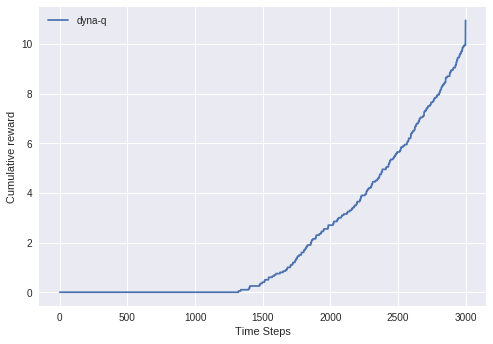

In [96]:
env = my_maze()
START_STATE = [6, 4]
STOP_STATE = [1, 9]
Maze1, Maze2, maxTimeSteps = blockingMaze()
implementBM()
plt.show()

#### 2) Implement Dyna-Q and Dyna-Q+

3000
3000
3000
3000


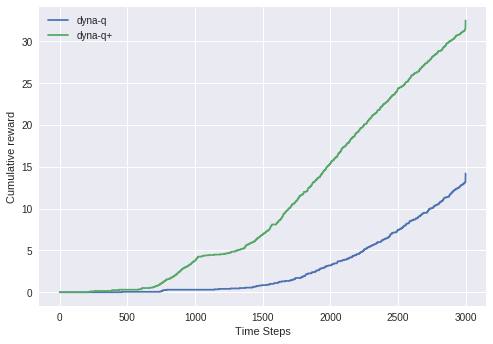

In [92]:
env = my_maze()
START_STATE = [6, 4]
STOP_STATE = [1, 9]
Maze1, Maze2, maxTimeSteps = blockingMaze()
implementBM()
plt.show()

```
Dyna-Q+ is Dyna-Q with an exploration bonus that encourages exploration. From the figure above it is clear that Dyna-Q+ performs much better after the model changing.
```

### 5. Shortcut Maze Experiments
#### 1) Define shortcut maze environment

In [0]:
def shortcurMaze():
    """ draw the maze, set the start and goal state
    :return:
    """
    # blocking maze would change to 2 after 1000 steps
    Shortcut_Maze_1 = ['###########',
                       '#         #',
                       '#         #',
                       '#         #',
                       '# #########',
                       '#         #',
                       '#   P     #',
                       '###########']

    Shortcut_Maze_2 = ['###########',
                       '#         #',
                       '#         #',
                       '#         #',
                       '# ####### #',
                       '#         #',
                       '#   P     #',
                       '###########']

    maxTimeSteps = 6000

    return Shortcut_Maze_1, Shortcut_Maze_2, maxTimeSteps


def implementSM():

    maze = Maze1
    maze_height = len(maze)
    maze_width = len(maze[0])

    game = env.make_game(maze)
    game.its_showtime()

    Q = np.random.rand(maze_height, maze_width, 4)

    steps2change = 3000

    dynaparams = DynaParams()
    dynaparams.alpha = 0.7
    dynaparams.planSteps = 5
    dynaparams.eps = 0.1

    """ get the cumulative reward used for plotting and change the maze after 1000 time steps """
    rewards = getReward(Q, dynaparams, game, maxTimeSteps, steps2change, maze)

    """ plot figure of example 8.3 """
    plt.figure(2)
    for i in range(0, 2):
        plt.plot(range(0, maxTimeSteps), rewards[i, :], label=dynaparams.method[i])

    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative reward')
    plt.legend()

#### 2) Implement Dyna-Q and Dyna-Q+ 

6000


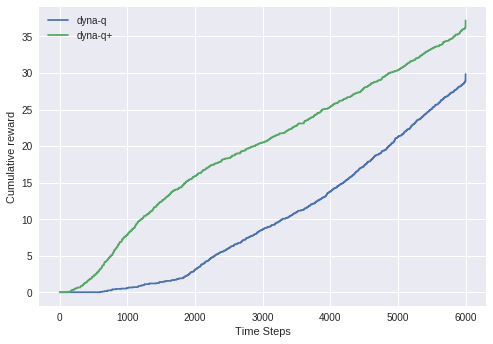

In [93]:
Maze1, Maze2, maxTimeSteps = shortcurMaze()
implementSM()

plt.show()

```
The general problem for implementing and comparing Dyna-Q and Dyna-Q+ here is the conflict between exploration and exploitation. We want the agent to explore to find changes in the nvironment, but not so much that performance is greatly degraded. Therefore, more experiments with different hyperparameter is necessary.  
```
```
The Dyna-Q+ agent did solve the shortcut maze problem. This agent keeps track for each state-action pair of how many time steps have elapsed since the pair was last tried in a real interaction with the environment. To encourage behavior that tests long-untried actions, a special "bonus reward" is given on simulated experiences involving these actions.
```

## Dyna-Q with Experience Replay
&nbsp;&nbsp;&nbsp;&nbsp; Experience replay can be interpreted as a planning method, because it is comparable to Dyna with a look-up table. However, the key difference is that Dyna only samples *states*, while experience replay samples *full* transitions, which may be biased and potentially harmful. The implementation of experience replay in this case is to replace the direct RL Q-learning update to buffer Q-learning. While for the Q-learning update in model planning part still remain using original Dyna algorithm.  
&nbsp;&nbsp;&nbsp;&nbsp; The idea of experience replay is to train the agent with the transitions sampled from a buffer of previously experienced transitions. A transition is defined to be a quadruple `(s,a,r,s')`, where `s` is the state, `a` is the action, `r` is the received reward after executing the action `a` in the state `s` and `s'` is the next state. At each time step, the current transition is added to the replay buffer and some transitions are sampled from the replay buffer to train the agent.  
 

| Dyna-Q with **experience replay** algorithm        | 
| -------------                            |
| Initialize `Q(s,a)` and Model`(s,a)` for all $s\in S$ and $a\in A(s)$      |  
| Initialize the Replay Buffer `M`    |     
| Get the initial state `s`        |
| while s is not the terminal state do:|
|&nbsp;&nbsp;&nbsp;&nbsp;select an action `a` according to current value function `q`    |
|&nbsp;&nbsp;&nbsp;&nbsp;Execuate the action `a`, get the reward `r` and next state `s'`   |
|&nbsp;&nbsp;&nbsp;&nbsp;**Store the transition `(s,a,r,s')` into the replay buffer `M`**|
|&nbsp;&nbsp;&nbsp;&nbsp;**Sample a batch of transitions $\epsilon$ from `M`**|
|&nbsp;&nbsp;&nbsp;&nbsp;Update the value function `q` with $\epsilon$   |
|&nbsp;&nbsp;&nbsp;&nbsp;`s=s'`|
|&nbsp;&nbsp;&nbsp;&nbsp;Model`(s,a)` $\leftarrow $`r, s'`|  
|&nbsp;&nbsp;&nbsp;&nbsp;Repeat n times:                  |
|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`s` <-- random previously observed state|
|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`a` <-- random action previously taken in `s`|
|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`r,s'` <-- Model(s,a)|
|&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;q(s,a) <-- q(s,a) + alpha[r + gamma]max_a * `q(s',a)` - `q(s,a)`|
|&nbsp;&nbsp;&nbsp;&nbsp;End|
|End|

